<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Functions

In [108]:
# imports and constants
import json
import pickle

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

In [7]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [8]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [112]:
def filter_sig_corrs(r_corrs, r_p_vals, cols, target_col, filter_prefix="", alpha=0.05):
    """Builds a df with correlations for the target_col, optionally providing a prefix filter for columns
    
    """
    target_idx = np.where(cols==target_col)
    target_corrs = r_corrs[target_idx]
    target_p_vals = r_p_vals[target_idx]

    target_stats = np.transpose(np.vstack((target_corrs, target_p_vals)))
    target_df = pd.DataFrame(target_stats, index=cols, columns=['corr', 'p'])
    sig_features = target_df.loc[target_df['p'] < alpha]
    sig_features = sig_features.loc[sig_features.index.str.startswith(filter_prefix)]
    pd.options.display.float_format = '{:,.3f}'.format

    return sig_features.sort_values(by='p')


def build_partial_corr(corr_df, target, covar, pval=0.05):
    """
    Builds partial correlation DataFrame from corr_df of the target survey, controlling for covars.
    
    Args:
        covars (list): list of covariates to control for
    """
    
    partial_corr = pg.pairwise_corr(data=corr_df, covar=[covar], method='pearson')
    partial_corr = partial_corr.loc[(partial_corr['p-unc'] < pval) & (partial_corr['X'].str.contains(target)) & (~partial_corr['Y'].str.contains(target))]
    partial_corr['r_ctl'] = partial_corr['r']
    partial_corr['p_ctl'] = partial_corr['p-unc']

    partial_corr = partial_corr[['X', 'Y', 'covar', 'r_ctl', 'p_ctl']]

    pairwise_corr = pg.pairwise_corr(data=corr_df, method='pearson')
    pairwise_corr['r_unctl'] = pairwise_corr['r']
    pairwise_corr['p_unctl'] = pairwise_corr['p-unc']

    partial_corr = partial_corr.merge(pairwise_corr[['X', 'Y', 'r_unctl', 'p_unctl']], on=['X', 'Y'], how='left')
    return partial_corr

# Load Data

In [9]:
baseline_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)
wk1_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419.xlsx",
                       sheet_name=2)
mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

In [90]:
redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

str_redcap_dict = {}
for k,v in redcap_dict.items():
    v_str = str(v)
    if len(v_str) < 8:
        v_str = '0' + v_str
        
    str_redcap_dict[k] = v_str

In [29]:
all_fga = pd.read_pickle("ls_data/all_fga.df")
all_scr = pd.read_pickle("ls_data/all_scr.df")

## Build Demographics DF

In [91]:
demo_df = pd.DataFrame()
demo_df['study_id'] = baseline_df['study_id']
demo_df['pid'] = demo_df['study_id'].map(str_redcap_dict)
demo_df['age'] = baseline_df['age']
demo_df['gender'] = baseline_df['demo_gender']


In [92]:
demo_df['employment'] = baseline_df['routine_slabels02']

employment_dict = {
    1: 'employed',
    2: 'unemployed',
    3: 'disability',
    4: 'retired',
    88: 'other',
    99: 'pna'
}

demo_df['employment'] = demo_df['employment'].map(employment_dict)

demo_df['employment'].value_counts()

employed      218
unemployed     23
disability     17
other          13
retired        10
pna             1
Name: employment, dtype: int64

In [93]:
demo_df['marital_status'] = baseline_df['demo_maritalstatus']

marital_dict = {
    0: 'single',
    1: 'live_with_partner',
    2: 'domestic_partnership',
    3: 'married',
    4: 'separated',
    5: 'divorced',
    6: 'dont_know',
    99: 'pna'
}

demo_df['marital_status'] = demo_df['marital_status'].map(marital_dict)

demo_df['marital_status'].value_counts()

single                  101
married                  92
live_with_partner        41
divorced                 33
separated                 6
domestic_partnership      6
pna                       2
dont_know                 1
Name: marital_status, dtype: int64

In [94]:
demo_df['education'] = baseline_df['demo_highest_education']

edu_dict = {
    1: 'never_attended', 
    2: '1st_grade',
    3: '2nd_grade', 
    4: '3rd_grade', 
    5: '4th_grade', 
    6: '5th_grade', 
    7: '6th_grade', 
    8: '7th_grade', 
    9: '8th_grade', 
    10: '9th_grade', 
    11: '10th_grade', 
    12: '11th_grade' , 
    13: '12th_grade_no_diploma', 
    14: 'high_school', 
    15: 'ged', 
    16: 'some_college',
    17: 'associates_vocational',
    18: 'associates_academic',
    19: 'bachelors',
    20: 'masters',
    21: 'professional_degree', 
    22: 'doctoral_degree', 
    23: 'dont_know', 
    99: 'pna'
}

demo_df['education'] = demo_df['education'].map(edu_dict)

demo_df['education'].value_counts()

bachelors                99
masters                  62
some_college             47
associates_vocational    26
associates_academic      13
doctoral_degree          12
professional_degree       7
high_school               7
ged                       6
11th_grade                1
10th_grade                1
12th_grade_no_diploma     1
Name: education, dtype: int64

In [95]:
demo_df['fam_income'] = baseline_df['demo_fam_income']
demo_df['ind_income'] = baseline_df['demo_personal_income']
income_dict = {
    1: '<10000',
    2: '10000-19999',
    3: '20000-39999',
    4: '40000-59999',
    5: '60000-99999',
    6: '>100000',
    7: 'dont_know',
    99: 'pna'
}

demo_df['fam_income'] = demo_df['fam_income'].map(income_dict)
demo_df['ind_income'] = demo_df['ind_income'].map(income_dict)


In [96]:
demo_df['fam_income'].value_counts()

60000-99999    88
40000-59999    59
>100000        49
20000-39999    44
10000-19999    20
<10000         13
pna             5
dont_know       4
Name: fam_income, dtype: int64

In [97]:
demo_df['ind_income'].value_counts()

40000-59999    71
20000-39999    60
60000-99999    54
10000-19999    40
<10000         39
>100000        12
pna             4
dont_know       2
Name: ind_income, dtype: int64

## Build Initial State DF

In [172]:
init_df = pd.DataFrame()
init_df['study_id'] = baseline_df['study_id']
init_df['pid'] = init_df['study_id'].map(redcap_dict)
init_df['pid'] = init_df['pid'].astype(str)
init_df['pid'] = init_df['pid'].str.pad(width=8, side='left', fillchar='0')

# phq
init_df['phq8'] = baseline_df['phq_total_sc']
init_df['phq_q10'] = baseline_df['phq10_sc']

# gad
init_df['gad7'] = baseline_df['gad_total']
init_df['gad_q8'] = baseline_df['gad08']
init_df.loc[97, 'gad7'] = (107-98)
init_df['gad7']

# shaps
init_df['shaps'] = baseline_df['shaps_score']

shaps_cols = baseline_df.columns[baseline_df.columns.str.contains('shaps')][:-1]
shaps_df = baseline_df[shaps_cols]
shaps_df = shaps_df.replace(to_replace=99, value=3)
init_df['shaps_sum'] = shaps_df.sum(axis=1)

# diagnoses
dx_cols = baseline_df.columns[baseline_df.columns.str.startswith('dx')]
dx_cols = dx_cols.drop(['dx_schizo', 'dx_bipolar'])
dx_df = baseline_df[dx_cols]
dx_df = dx_df.replace(to_replace=99, value=0)
dx_df = dx_df.replace(to_replace=77, value=0)
init_df[dx_cols] = dx_df[dx_cols]

In [173]:
# spin
fear = [1,3,5,10,14,15]
avoid = [4,6,8,9,10,11,16]
physio = [2,7,13,17]
mini = [6,9,15]

def proc_spin_cols(qs):
    col_names = []
    for q in qs:
        name = "spin_0{}" if q < 10 else "spin_{}"
        col_names.append(name.format(q))
    return col_names

fear_cols = proc_spin_cols(fear)
avoid_cols = proc_spin_cols(avoid)
phys_cols = proc_spin_cols(avoid)
mini_cols = proc_spin_cols(mini)

spin_cols = baseline_df.columns[baseline_df.columns.str.contains('spin')][:-1]
spin_df = baseline_df[spin_cols]
spin_df = spin_df.replace(to_replace=999, value=1)
spin_df['spin_fear'] = spin_df[fear_cols].sum(axis=1)
spin_df['spin_avoid'] = spin_df[avoid_cols].sum(axis=1)
spin_df['spin_phys'] = spin_df[phys_cols].sum(axis=1)
spin_df['spin_mini'] = spin_df[mini_cols].sum(axis=1)
spin_df['spin_total'] = spin_df[spin_cols].sum(axis=1)
spin_cols = ['spin_total', 'spin_fear', 'spin_avoid', 'spin_phys', 'spin_mini']
init_df[spin_cols] = spin_df[spin_cols]

In [174]:
init_df.head()

,study_id,pid,phq8,phq_q10,gad7,gad_q8,shaps,shaps_sum,dx_depression,dx_ocd,dx_ptsd,dx_eating,dx_substance,spin_total,spin_fear,spin_avoid,spin_phys,spin_mini
0,601011,91048552,3,1.000,0,0.000,0,52,0,0,0,0,0,2,1,1,1,1
1,601012,31456993,15,1.000,15,2.000,5,39,1,0,1,0,0,30,11,13,13,6
2,601013,51735262,4,0.000,11,1.000,0,51,0,0,0,0,0,8,4,2,2,1
3,601014,69452375,7,2.000,7,1.000,3,44,0,0,0,0,0,23,10,17,17,4
4,601015,28021601,1,1.000,0,0.000,0,55,1,0,0,0,0,2,0,2,2,0


## Correlations

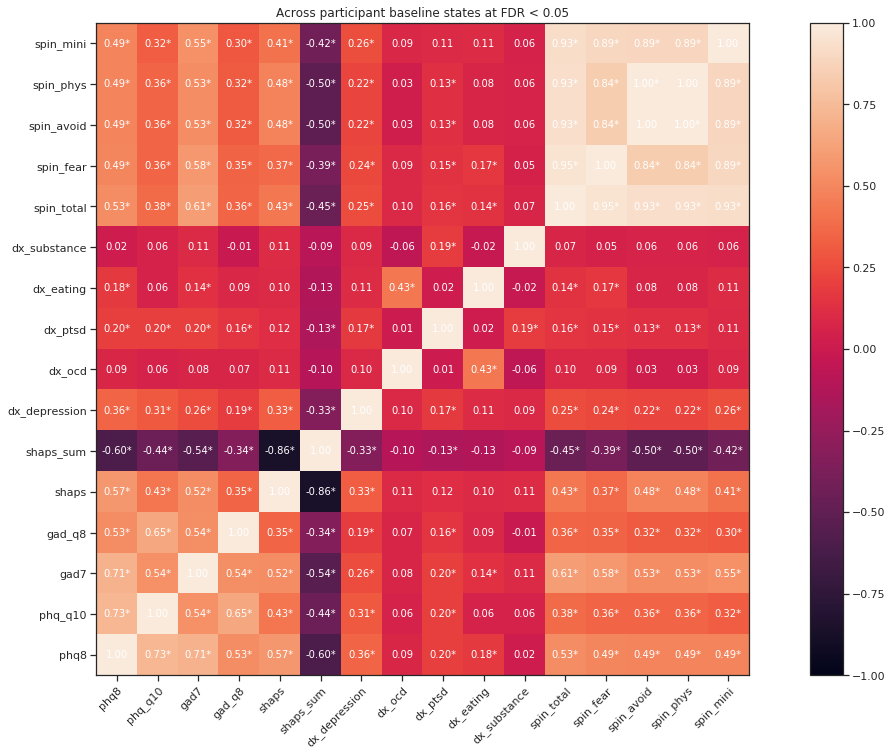

In [288]:
corr_df = init_df.copy()
corr_df = corr_df.drop(['pid', 'study_id'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant baseline states at FDR < 0.05', 0.05, figsize=[22,12])
plt.show()

## Build App DF

In [175]:
apps = [
    'katana',
    'orca', 
    'messaging',
    'launcher',
    'chrome',
    'email',
    'instagram',
    'youtube',
    'maps',
    'snapchat',
    'browser'
]

In [176]:
all_fga[apps] = all_fga[apps].clip(lower=0)
all_fga['date'] = all_fga['hr'].dt.floor('d')

In [177]:
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()

In [178]:
fga_daily = fga_daily.loc[(fga_daily['date'] >= '2019-07-30') & (fga_daily['date'] <= '2019-08-07')]

In [179]:
all_scr['date'] = all_scr['hr'].dt.floor('d')
scr_daily = all_scr.groupby(['pid', 'date']).sum()
scr_daily = scr_daily.reset_index()
scr_daily = scr_daily.loc[(scr_daily['date'] >= '2019-07-30') & (scr_daily['date'] <= '2019-08-07')]

In [180]:
fga_daily = fga_daily.merge(scr_daily, on=['pid', 'date'], how='left')
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)
fga_mean = fga_daily.groupby('pid', as_index=False).mean()

fga_daily.describe()

,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,duration,transitions,is_wkday
count,"2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,447.000","2,447.000","2,481.000"
mean,"1,489.510",226.260,971.986,"2,376.241","1,871.144",47.241,473.198,935.700,401.342,97.198,181.079,"14,577.313",124.540,0.777
std,"2,750.172",925.241,"1,670.616","3,742.906","3,431.834",218.650,"1,192.351","3,762.191","1,331.965",419.194,776.265,"8,725.951",106.324,0.416
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,534.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,"8,081.500",51.000,1.000
50%,30.000,0.000,245.000,"1,300.000",631.000,0.000,0.000,0.000,0.000,0.000,0.000,"13,962.000",97.000,1.000
75%,"1,865.000",60.000,"1,219.000","2,831.000","2,232.000",0.000,216.000,60.000,105.000,0.000,0.000,"20,331.000",166.000,1.000
max,"20,526.000","14,697.000","19,975.000","58,938.000","40,185.000","3,947.000","15,024.000","58,634.000","21,205.000","5,759.000","15,499.000","52,721.000",853.000,1.000


In [181]:
fga_daily.head()

,pid,date,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,duration,transitions,is_wkday
0,00746649,2019-07-30,0.000,75.000,"2,891.000","1,996.000",675.000,309.000,"3,306.000",172.000,0.000,0.000,"1,086.000","13,808.000",230.000,1.000
1,00746649,2019-07-31,0.000,779.000,838.000,"3,375.000",0.000,165.000,286.000,0.000,0.000,0.000,"1,044.000","10,872.000",153.000,1.000
2,00746649,2019-08-01,0.000,444.000,"2,352.000",740.000,90.000,170.000,612.000,0.000,"1,489.000",0.000,568.000,"10,246.000",232.000,1.000
3,00746649,2019-08-02,0.000,180.000,"2,236.000",544.000,0.000,496.000,"1,100.000",210.000,"6,519.000",0.000,"2,115.000","14,257.000",375.000,1.000
4,00746649,2019-08-03,0.000,15.000,"5,896.000",747.000,585.000,531.000,726.000,0.000,0.000,0.000,"1,059.000","15,722.000",177.000,0.000


# Snapchat

## Users vs Non-Users

In [182]:
fga_mean['use_snapchat'] = (fga_mean['snapchat'] > 0).astype(int)

In [183]:
sc_users = fga_mean.loc[fga_mean['snapchat'] > 0]['pid']
sc_nonusers = fga_mean.loc[fga_mean['snapchat'] <= 0]['pid']

In [184]:
print("Snapchat users")
display(demo_df.loc[demo_df['pid'].isin(sc_users)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(sc_users)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(sc_users)]['education'].value_counts())

Snapchat users


count   68.000
mean    30.118
std      7.290
min     19.000
25%     26.000
50%     28.000
75%     33.250
max     55.000
Name: age, dtype: float64

0    52
1    16
Name: gender, dtype: int64

bachelors                29
some_college             12
masters                  12
associates_vocational     6
associates_academic       2
high_school               2
doctoral_degree           2
professional_degree       1
ged                       1
12th_grade_no_diploma     1
Name: education, dtype: int64

In [185]:
print("Snapchat non-users")
display(demo_df.loc[demo_df['pid'].isin(sc_nonusers)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(sc_nonusers)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(sc_nonusers)]['education'].value_counts())

Snapchat non-users


count   209.000
mean     41.823
std      11.825
min      20.000
25%      32.000
50%      41.000
75%      52.000
max      69.000
Name: age, dtype: float64

0    166
1     43
Name: gender, dtype: int64

bachelors                67
masters                  50
some_college             34
associates_vocational    20
associates_academic      10
doctoral_degree          10
professional_degree       6
ged                       5
high_school               5
11th_grade                1
10th_grade                1
Name: education, dtype: int64

### Correlations

In [201]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
#corr_df = corr_df.merge(fga_mean[['pid', 'snapchat', 'use_snapchat']], on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

#corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'study_id'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
print("Significant correlations with using snapchat")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'use_snapchat')

Significant correlations with using snapchat


,corr,p
snapchat,0.987,0.000
age,-0.445,0.000
instagram,0.326,0.000
transitions,0.303,0.000
dx_eating,0.204,0.003
maps,0.178,0.012
youtube,0.156,0.033


In [203]:
print("Pairwise correlations with using snapchat")
pg.pairwise_corr(data=corr_df, columns=['use_snapchat', 'dx_eating', 'age', 'gender'], method='spearman', padjust='fdr_bh')

Pairwise correlations with using snapchat


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
0,use_snapchat,dx_eating,spearman,two-sided,278,0.204,"[0.09, 0.31]",0.042,0.035,0.207,0.001,0.002,fdr_bh,0.930
1,use_snapchat,age,spearman,two-sided,277,-0.445,"[-0.54, -0.35]",0.198,0.192,-0.478,0.000,0.000,fdr_bh,1.000
2,use_snapchat,gender,spearman,two-sided,277,0.031,"[-0.09, 0.15]",0.001,-0.006,0.031,0.607,0.728,fdr_bh,0.081
3,dx_eating,age,spearman,two-sided,281,-0.112,"[-0.23, 0.01]",0.013,0.005,-0.112,0.061,0.121,fdr_bh,0.468
4,dx_eating,gender,spearman,two-sided,281,-0.104,"[-0.22, 0.01]",0.011,0.004,-0.104,0.082,0.123,fdr_bh,0.414
5,age,gender,spearman,two-sided,281,0.015,"[-0.1, 0.13]",0.000,-0.007,0.015,0.801,0.801,fdr_bh,0.057


In [204]:
print("Partial correlations with use_snapchat: dx_eating")
pg.partial_corr(data=corr_df, x='use_snapchat', y='dx_eating', covar=['age', 'gender'], method='spearman')

Partial correlations with use_snapchat: dx_eating


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,277,0.277,"[0.16, 0.38]",0.077,0.070,0.000,0.997


## Within Snapchat users

In [207]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

corr_df = corr_df.loc[corr_df['use_snapchat'] == 1]
corr_df = corr_df.drop(['pid', 'study_id', 'use_snapchat'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)

print("Significant correlations within snapchat users")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'snapchat')
#plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across snapchat user correlations at FDR < 0.05', 0.05, figsize=[22,12])
#plt.show()

Significant correlations within snapchat users


,corr,p
age,-0.386,0.010


In [198]:
corr_df['dx_eating'].value_counts()

0    58
1    10
Name: dx_eating, dtype: int64

In [199]:
init_df['dx_eating'].value_counts()

0    263
1     19
Name: dx_eating, dtype: int64

# Instagram

## Users vs Non-Users

In [219]:
fga_mean['use_instagram'] = (fga_mean['instagram'] > 0).astype(int)

In [220]:
insta_users = fga_mean.loc[fga_mean['instagram'] > 0]['pid']
insta_nonusers = fga_mean.loc[fga_mean['instagram'] <= 0]['pid']

In [221]:
print("instagram users")
display(demo_df.loc[demo_df['pid'].isin(insta_users)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(insta_users)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(insta_users)]['education'].value_counts())

instagram users


count   128.000
mean     34.188
std      10.657
min      20.000
25%      27.000
50%      31.000
75%      40.000
max      64.000
Name: age, dtype: float64

0    105
1     23
Name: gender, dtype: int64

bachelors                55
masters                  24
some_college             23
associates_vocational     6
doctoral_degree           6
professional_degree       4
associates_academic       3
ged                       3
high_school               3
12th_grade_no_diploma     1
Name: education, dtype: int64

In [222]:
print("instagram non-users")
display(demo_df.loc[demo_df['pid'].isin(insta_nonusers)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(insta_nonusers)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(insta_nonusers)]['education'].value_counts())

instagram non-users


count   149.000
mean     43.040
std      11.583
min      19.000
25%      34.000
50%      42.000
75%      53.000
max      69.000
Name: age, dtype: float64

0    113
1     36
Name: gender, dtype: int64

bachelors                41
masters                  38
some_college             23
associates_vocational    20
associates_academic       9
doctoral_degree           6
high_school               4
professional_degree       3
ged                       3
10th_grade                1
11th_grade                1
Name: education, dtype: int64

### Correlations

In [223]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
#corr_df = corr_df.merge(fga_mean[['pid', 'instagram', 'use_instagram']], on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

#corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'study_id'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
print("Significant correlations with using instagram")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'use_instagram')

Significant correlations with using instagram


,corr,p
instagram,0.939,0.000
age,-0.390,0.000
transitions,0.286,0.000
snapchat,0.277,0.000
use_snapchat,0.276,0.000
duration,0.250,0.000
maps,0.221,0.001
youtube,0.213,0.002
orca,0.212,0.002
katana,0.209,0.002


In [224]:
print("Pairwise correlations with using instagram")
pg.pairwise_corr(data=corr_df, columns=['use_instagram', 'dx_eating', 'age', 'gender'], method='spearman', padjust='fdr_bh')

Pairwise correlations with using instagram


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
0,use_instagram,dx_eating,spearman,two-sided,278,0.094,"[-0.02, 0.21]",0.009,0.002,0.094,0.119,0.179,fdr_bh,0.345
1,use_instagram,age,spearman,two-sided,277,-0.390,"[-0.49, -0.29]",0.152,0.146,-0.412,0.000,0.000,fdr_bh,1.000
2,use_instagram,gender,spearman,two-sided,277,-0.075,"[-0.19, 0.04]",0.006,-0.002,-0.075,0.211,0.253,fdr_bh,0.240
3,dx_eating,age,spearman,two-sided,281,-0.112,"[-0.23, 0.01]",0.013,0.005,-0.112,0.061,0.163,fdr_bh,0.468
4,dx_eating,gender,spearman,two-sided,281,-0.104,"[-0.22, 0.01]",0.011,0.004,-0.104,0.082,0.163,fdr_bh,0.414
5,age,gender,spearman,two-sided,281,0.015,"[-0.1, 0.13]",0.000,-0.007,0.015,0.801,0.801,fdr_bh,0.057


In [225]:
print("Partial correlations with use_instagram: dx_eating")
pg.partial_corr(data=corr_df, x='use_instagram', y='dx_eating', covar=['age', 'gender'], method='spearman')

Partial correlations with use_instagram: dx_eating


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,277,0.123,"[0.0, 0.24]",0.015,0.008,0.041,0.534


## Within instagram users

In [226]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

corr_df = corr_df.loc[corr_df['use_instagram'] == 1]
corr_df = corr_df.drop(['pid', 'study_id', 'use_instagram'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)

print("Significant correlations within instagram users")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'instagram')
#plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across instagram user correlations at FDR < 0.05', 0.05, figsize=[22,12])
#plt.show()

Significant correlations within instagram users


,corr,p
transitions,0.372,0.000
snapchat,0.258,0.021
use_snapchat,0.253,0.025


# Facebook (app)

## Users vs Non-Users

In [227]:
fga_mean['use_katana'] = (fga_mean['katana'] > 0).astype(int)

In [228]:
katana_users = fga_mean.loc[fga_mean['katana'] > 0]['pid']
katana_nonusers = fga_mean.loc[fga_mean['katana'] <= 0]['pid']

In [229]:
print("katana users")
display(demo_df.loc[demo_df['pid'].isin(katana_users)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(katana_users)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(katana_users)]['education'].value_counts())

katana users


count   180.000
mean     39.528
std      12.178
min      19.000
25%      29.000
50%      37.500
75%      49.000
max      69.000
Name: age, dtype: float64

0    145
1     35
Name: gender, dtype: int64

bachelors                63
masters                  41
some_college             31
associates_vocational    14
doctoral_degree           8
associates_academic       7
high_school               6
ged                       4
professional_degree       3
11th_grade                1
10th_grade                1
12th_grade_no_diploma     1
Name: education, dtype: int64

In [273]:
print("katana non-users")
display(demo_df.loc[demo_df['pid'].isin(katana_nonusers)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(katana_nonusers)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(katana_nonusers)]['education'].value_counts())

katana non-users


count   97.000
mean    37.876
std     11.619
min     20.000
25%     29.000
50%     35.000
75%     45.000
max     65.000
Name: age, dtype: float64

0    73
1    24
Name: gender, dtype: int64

bachelors                33
masters                  21
some_college             15
associates_vocational    12
associates_academic       5
professional_degree       4
doctoral_degree           4
ged                       2
high_school               1
Name: education, dtype: int64

### Correlations

In [231]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
#corr_df = corr_df.merge(fga_mean[['pid', 'katana', 'use_katana']], on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

#corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'study_id'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
print("Significant correlations with using katana")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'use_katana')

Significant correlations with using katana


,corr,p
katana,0.846,0.000
orca,0.475,0.000
duration,0.220,0.001
use_instagram,0.203,0.003
instagram,0.170,0.017
launcher,0.169,0.018


In [233]:
print("Pairwise correlations with using katana")
pg.pairwise_corr(data=corr_df, columns=['use_katana', 'duration', 'age', 'gender'], method='spearman', padjust='fdr_bh')

Pairwise correlations with using katana


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
0,use_katana,duration,spearman,two-sided,275,0.220,"[0.1, 0.33]",0.048,0.041,0.224,0.000,0.001,fdr_bh,0.959
1,use_katana,age,spearman,two-sided,277,0.065,"[-0.05, 0.18]",0.004,-0.003,0.065,0.283,0.367,fdr_bh,0.189
2,use_katana,gender,spearman,two-sided,277,-0.062,"[-0.18, 0.06]",0.004,-0.003,-0.062,0.306,0.367,fdr_bh,0.176
3,duration,age,spearman,two-sided,274,-0.146,"[-0.26, -0.03]",0.021,0.014,-0.147,0.016,0.031,fdr_bh,0.680
4,duration,gender,spearman,two-sided,274,-0.164,"[-0.28, -0.05]",0.027,0.020,-0.165,0.006,0.019,fdr_bh,0.780
5,age,gender,spearman,two-sided,281,0.015,"[-0.1, 0.13]",0.000,-0.007,0.015,0.801,0.801,fdr_bh,0.057


In [235]:
print("Partial correlations with use_katana: dx_eating")
pg.partial_corr(data=corr_df, x='use_katana', y='duration', covar=['age', 'gender'], method='spearman')

Partial correlations with use_katana: dx_eating


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,274,0.193,"[0.08, 0.3]",0.037,0.030,0.001,0.896


## Within katana users

In [236]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

corr_df = corr_df.loc[corr_df['use_katana'] == 1]
corr_df = corr_df.drop(['pid', 'study_id', 'use_katana'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)

print("Significant correlations within katana users")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'katana')
#plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across katana user correlations at FDR < 0.05', 0.05, figsize=[22,12])
#plt.show()

Significant correlations within katana users


,corr,p
orca,0.256,0.003
duration,0.213,0.020


# Facebook (Messenger)

## Users vs Non-Users

In [248]:
fga_mean['use_orca'] = (fga_mean['orca'] > 0).astype(int)

In [249]:
orca_users = fga_mean.loc[fga_mean['orca'] > 0]['pid']
orca_nonusers = fga_mean.loc[fga_mean['orca'] <= 0]['pid']

In [250]:
print("orca users")
display(demo_df.loc[demo_df['pid'].isin(orca_users)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(orca_users)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(orca_users)]['education'].value_counts())

orca users


count   175.000
mean     38.640
std      12.119
min      19.000
25%      29.000
50%      36.000
75%      46.500
max      69.000
Name: age, dtype: float64

0    145
1     30
Name: gender, dtype: int64

bachelors                60
masters                  42
some_college             29
associates_vocational    11
doctoral_degree          10
associates_academic       8
high_school               6
ged                       4
professional_degree       3
11th_grade                1
12th_grade_no_diploma     1
Name: education, dtype: int64

In [272]:
print("orca non-users")
display(demo_df.loc[demo_df['pid'].isin(orca_nonusers)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(orca_nonusers)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(orca_nonusers)]['education'].value_counts())

orca non-users


count   102.000
mean     39.480
std      11.806
min      20.000
25%      30.000
50%      37.000
75%      46.000
max      65.000
Name: age, dtype: float64

0    73
1    29
Name: gender, dtype: int64

bachelors                36
masters                  20
some_college             17
associates_vocational    15
professional_degree       4
associates_academic       4
ged                       2
doctoral_degree           2
high_school               1
10th_grade                1
Name: education, dtype: int64

### Correlations

In [252]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
#corr_df = corr_df.merge(fga_mean[['pid', 'orca', 'use_orca']], on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

#corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'study_id'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
print("Significant correlations with using orca")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'use_orca')

Significant correlations with using orca


,corr,p
katana,0.523,0.000
orca,0.856,0.000
use_katana,0.516,0.000
launcher,0.246,0.000
duration,0.237,0.000
use_instagram,0.200,0.004
instagram,0.198,0.004
spin_avoid,-0.154,0.036
spin_phys,-0.154,0.036


In [253]:
print("Pairwise correlations with using orca")
pg.pairwise_corr(data=corr_df, columns=['use_orca', 'spin_avoid', 'age', 'gender'], method='spearman', padjust='fdr_bh')

Pairwise correlations with using orca


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
0,use_orca,spin_avoid,spearman,two-sided,278,-0.154,"[-0.27, -0.04]",0.024,0.017,-0.155,0.010,0.060,fdr_bh,0.734
1,use_orca,age,spearman,two-sided,277,-0.042,"[-0.16, 0.08]",0.002,-0.006,-0.042,0.491,0.736,fdr_bh,0.106
2,use_orca,gender,spearman,two-sided,277,-0.133,"[-0.25, -0.02]",0.018,0.011,-0.134,0.027,0.081,fdr_bh,0.602
3,spin_avoid,age,spearman,two-sided,281,-0.087,"[-0.2, 0.03]",0.008,0.000,-0.087,0.146,0.293,fdr_bh,0.307
4,spin_avoid,gender,spearman,two-sided,281,-0.029,"[-0.15, 0.09]",0.001,-0.006,-0.029,0.634,0.761,fdr_bh,0.076
5,age,gender,spearman,two-sided,281,0.015,"[-0.1, 0.13]",0.000,-0.007,0.015,0.801,0.801,fdr_bh,0.057


In [255]:
print("Partial correlations with use_orca: spin_avoid")
pg.partial_corr(data=corr_df, x='use_orca', y='spin_avoid', covar=['age', 'gender'], method='spearman')

Partial correlations with use_orca: spin_avoid


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,277,-0.154,"[-0.27, -0.04]",0.024,0.016,0.010,0.728


## Within orca users

In [256]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

corr_df = corr_df.loc[corr_df['use_orca'] == 1]
corr_df = corr_df.drop(['pid', 'study_id', 'use_orca'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)

print("Significant correlations within orca users")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'orca')
#plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across orca user correlations at FDR < 0.05', 0.05, figsize=[22,12])
#plt.show()

Significant correlations within orca users


,corr,p
youtube,0.273,0.002
gad_q8,0.235,0.011
duration,0.223,0.017


In [258]:
print("Pairwise correlations within orca users")
pg.pairwise_corr(data=corr_df, columns=['orca', 'gad_q8', 'age', 'gender'], method='spearman', padjust='fdr_bh')

Pairwise correlations within orca users


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
0,orca,gad_q8,spearman,two-sided,176,0.235,"[0.09, 0.37]",0.055,0.044,0.239,0.002,0.010,fdr_bh,0.883
1,orca,age,spearman,two-sided,175,-0.181,"[-0.32, -0.03]",0.033,0.022,-0.183,0.016,0.049,fdr_bh,0.674
2,orca,gender,spearman,two-sided,175,-0.032,"[-0.18, 0.12]",0.001,-0.011,-0.032,0.675,0.809,fdr_bh,0.070
3,gad_q8,age,spearman,two-sided,175,-0.150,"[-0.29, -0.0]",0.022,0.011,-0.151,0.048,0.079,fdr_bh,0.510
4,gad_q8,gender,spearman,two-sided,175,-0.147,"[-0.29, 0.0]",0.022,0.010,-0.148,0.053,0.079,fdr_bh,0.494
5,age,gender,spearman,two-sided,175,-0.017,"[-0.17, 0.13]",0.000,-0.011,-0.017,0.819,0.819,fdr_bh,0.056


In [260]:
print("Partial correlations within orca users: gad q8")
pg.partial_corr(data=corr_df, x='orca', y='gad_q8', covar=['age', 'gender'], method='spearman')

Partial correlations within orca users: gad q8


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,175,0.228,"[0.08, 0.36]",0.052,0.041,0.002,0.862


# Messaging 

## Users vs Non-Users

In [274]:
fga_mean['use_messaging'] = (fga_mean['messaging'] > 0).astype(int)

In [275]:
messaging_users = fga_mean.loc[fga_mean['messaging'] > 0]['pid']
messaging_nonusers = fga_mean.loc[fga_mean['messaging'] <= 0]['pid']

In [276]:
print("messaging users")
display(demo_df.loc[demo_df['pid'].isin(messaging_users)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(messaging_users)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(messaging_users)]['education'].value_counts())

messaging users


count   219.000
mean     38.932
std      11.613
min      19.000
25%      30.000
50%      36.000
75%      46.000
max      69.000
Name: age, dtype: float64

0    171
1     48
Name: gender, dtype: int64

bachelors                78
masters                  53
some_college             31
associates_vocational    20
doctoral_degree          11
associates_academic       9
professional_degree       7
ged                       5
high_school               3
11th_grade                1
12th_grade_no_diploma     1
Name: education, dtype: int64

In [277]:
print("messaging non-users")
display(demo_df.loc[demo_df['pid'].isin(messaging_nonusers)]['age'].describe())
display(demo_df.loc[demo_df['pid'].isin(messaging_nonusers)]['gender'].value_counts())
display(demo_df.loc[demo_df['pid'].isin(messaging_nonusers)]['education'].value_counts())

messaging non-users


count   58.000
mean    39.017
std     13.429
min     20.000
25%     28.000
50%     39.500
75%     49.750
max     65.000
Name: age, dtype: float64

0    47
1    11
Name: gender, dtype: int64

bachelors                18
some_college             15
masters                   9
associates_vocational     6
high_school               4
associates_academic       3
10th_grade                1
ged                       1
doctoral_degree           1
Name: education, dtype: int64

### Correlations

In [278]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
#corr_df = corr_df.merge(fga_mean[['pid', 'messaging', 'use_messaging']], on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

#corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'study_id'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
print("Significant correlations with using messaging")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'use_messaging')

Significant correlations with using messaging


,corr,p
messaging,0.707,0.000
gad7,-0.158,0.033
maps,0.149,0.047


In [280]:
print("Pairwise correlations with using messaging")
pg.pairwise_corr(data=corr_df, columns=['use_messaging', 'gad7', 'age', 'gender'], method='spearman', padjust='fdr_bh')

Pairwise correlations with using messaging


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
0,use_messaging,gad7,spearman,two-sided,278,-0.158,"[-0.27, -0.04]",0.025,0.018,-0.159,0.008,0.050,fdr_bh,0.753
1,use_messaging,age,spearman,two-sided,277,0.012,"[-0.11, 0.13]",0.000,-0.007,0.012,0.846,0.846,fdr_bh,0.054
2,use_messaging,gender,spearman,two-sided,277,0.029,"[-0.09, 0.15]",0.001,-0.006,0.029,0.627,0.846,fdr_bh,0.077
3,gad7,age,spearman,two-sided,281,-0.136,"[-0.25, -0.02]",0.018,0.011,-0.137,0.023,0.069,fdr_bh,0.624
4,gad7,gender,spearman,two-sided,281,-0.046,"[-0.16, 0.07]",0.002,-0.005,-0.046,0.446,0.846,fdr_bh,0.119
5,age,gender,spearman,two-sided,281,0.015,"[-0.1, 0.13]",0.000,-0.007,0.015,0.801,0.846,fdr_bh,0.057


In [281]:
print("Partial correlations with use_messaging: gad7")
pg.partial_corr(data=corr_df, x='use_messaging', y='gad7', covar=['age', 'gender'], method='spearman')

Partial correlations with use_messaging: gad7


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,277,-0.092,"[-0.21, 0.03]",0.008,0.001,0.128,0.332


## Within messaging users

In [282]:
corr_df = init_df.copy()
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.merge(demo_df[['pid', 'age', 'gender']], on='pid', how='left')

corr_df = corr_df.loc[corr_df['use_messaging'] == 1]
corr_df = corr_df.drop(['pid', 'study_id', 'use_messaging'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)

print("Significant correlations within messaging users")
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'messaging')
#plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across messaging user correlations at FDR < 0.05', 0.05, figsize=[22,12])
#plt.show()

Significant correlations within messaging users


,corr,p
launcher,0.350,0.000
transitions,0.224,0.005
phq8,-0.208,0.011
spin_avoid,-0.195,0.021
spin_phys,-0.195,0.021
spin_total,-0.194,0.021
spin_fear,-0.174,0.047
browser,0.174,0.047


In [283]:
print("Pairwise correlations within messaging users")
pg.pairwise_corr(data=corr_df, columns=['messaging', 'phq8', 'spin_total', 'age', 'gender'], method='spearman', padjust='fdr_bh')

Pairwise correlations within messaging users


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
0,messaging,phq8,spearman,two-sided,220,-0.208,"[-0.33, -0.08]",0.043,0.034,-0.211,0.002,0.010,fdr_bh,0.875
1,messaging,spin_total,spearman,two-sided,220,-0.194,"[-0.32, -0.06]",0.038,0.029,-0.196,0.004,0.013,fdr_bh,0.826
2,messaging,age,spearman,two-sided,219,0.038,"[-0.09, 0.17]",0.001,-0.008,0.038,0.571,0.602,fdr_bh,0.087
3,messaging,gender,spearman,two-sided,219,-0.112,"[-0.24, 0.02]",0.013,0.003,-0.112,0.098,0.246,fdr_bh,0.381
4,phq8,spin_total,spearman,two-sided,220,0.517,"[0.41, 0.61]",0.267,0.260,0.572,0.000,0.000,fdr_bh,1.000
5,phq8,age,spearman,two-sided,219,0.069,"[-0.06, 0.2]",0.005,-0.004,0.069,0.310,0.442,fdr_bh,0.174
6,phq8,gender,spearman,two-sided,219,-0.078,"[-0.21, 0.06]",0.006,-0.003,-0.078,0.252,0.419,fdr_bh,0.209
7,spin_total,age,spearman,two-sided,219,-0.062,"[-0.19, 0.07]",0.004,-0.005,-0.062,0.359,0.449,fdr_bh,0.151
8,spin_total,gender,spearman,two-sided,219,-0.079,"[-0.21, 0.05]",0.006,-0.003,-0.079,0.246,0.419,fdr_bh,0.213
9,age,gender,spearman,two-sided,219,-0.035,"[-0.17, 0.1]",0.001,-0.008,-0.035,0.602,0.602,fdr_bh,0.082


In [284]:
print("Partial correlations within messaging users: spin_total")
pg.partial_corr(data=corr_df, x='messaging', y='spin_total', covar=['age', 'gender'], method='spearman')

Partial correlations within messaging users: spin_total


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,219,-0.200,"[-0.32, -0.07]",0.040,0.031,0.003,0.846


In [285]:
print("Partial correlations within messaging users: phq8")
pg.partial_corr(data=corr_df, x='messaging', y='phq8', covar=['age', 'gender'], method='spearman')

Partial correlations within messaging users: phq8


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,219,-0.203,"[-0.33, -0.07]",0.041,0.033,0.002,0.860
